In [ ]:
# PaliGemma Vision-Language Model for Medical VQA

This notebook implements:
- Zero-shot inference using PaliGemma
- Evaluation on closed-ended and open-ended questions
- LoRA fine-tuning experiments
- Comparative analysis with CNN-GRU baseline
- Qualitative analysis of generated answers

Dataset: VQA-RAD


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
GPU name: Tesla T4


In [ ]:
#Mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = "/content/drive/MyDrive/WOA7015_MedVQA"
os.makedirs(base_path, exist_ok=True)

print("Project directory:", base_path)


Project directory: /content/drive/MyDrive/WOA7015_MedVQA


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/VQA.zip"
extract_path = "/content/drive/MyDrive/WOA7015_MedVQA/data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP extracted successfully!")

ZIP extracted successfully!


In [ ]:
#Check dataset folder
!ls /content/drive/MyDrive/WOA7015_MedVQA/data/

 Readme.docx		       'VQA_RAD Dataset Public.xml'
'VQA_RAD Dataset Public.json'  'VQA_RAD Image Folder'
'VQA_RAD Dataset Public.xlsx'


In [ ]:
#Load & Inspect the Dataset
import os
import json

base_path = "/content/drive/MyDrive/WOA7015_MedVQA/data"

image_dir = os.path.join(base_path, "VQA_RAD Image Folder")
json_path = os.path.join(base_path, "VQA_RAD Dataset Public.json")

print("Image folder exists:", os.path.exists(image_dir))
print("JSON file exists:", os.path.exists(json_path))

Image folder exists: True
JSON file exists: True


In [ ]:
#Dataset Structure and Load the JSON File
with open(json_path, "r") as f:
    data = json.load(f)

print("Total QA samples:", len(data))
print("Sample entry:")
data[0]

Total QA samples: 2248
Sample entry:


{'qid': '0',
 'phrase_type': 'freeform',
 'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642',
 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6',
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'evaluation': 'not evaluated',
 'question': 'Are regions of the brain infarcted?',
 'question_rephrase': 'NULL',
 'question_relation': 'NULL',
 'question_frame': 'NULL',
 'question_type': 'PRES',
 'answer': 'Yes',
 'answer_type': 'CLOSED'}

In [ ]:
#Inspect One Sample
sample = data[0]

print("Image:", sample["image_name"])
print("Question:", sample["question"])
print("Answer:", sample["answer"])
print("Type:", sample["question_type"])


Image: synpic54610.jpg
Question: Are regions of the brain infarcted?
Answer: Yes
Type: PRES


In [ ]:
#Question Type Distribution
def is_yes_no(ans):
    return isinstance(ans, str) and ans.lower() in ["yes", "no"]

yes_no = sum(is_yes_no(x["answer"]) for x in data)
open_ended = len(data) - yes_no

print("Yes/No questions:", yes_no)
print("Open-ended questions:", open_ended)

Yes/No questions: 1193
Open-ended questions: 1055


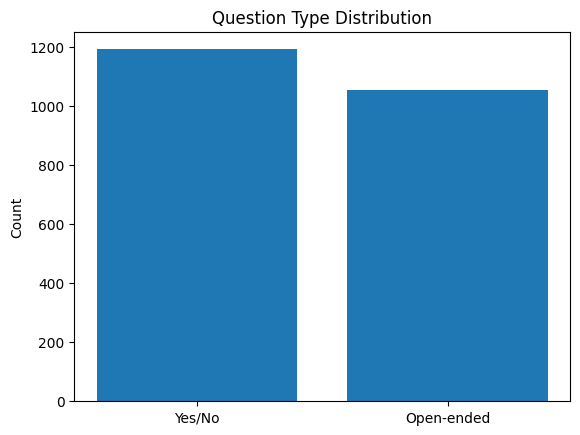

In [ ]:
#bar chart
import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Yes/No", "Open-ended"], [yes_no, open_ended])
plt.title("Question Type Distribution")
plt.ylabel("Count")
plt.show()


In [ ]:
#Question Length
question_lengths = [len(x["question"].split()) for x in data]

print("Avg question length:", sum(question_lengths)/len(question_lengths))
print("Min question length:", min(question_lengths))
print("Max question length:", max(question_lengths))


Avg question length: 6.814946619217082
Min question length: 3
Max question length: 22


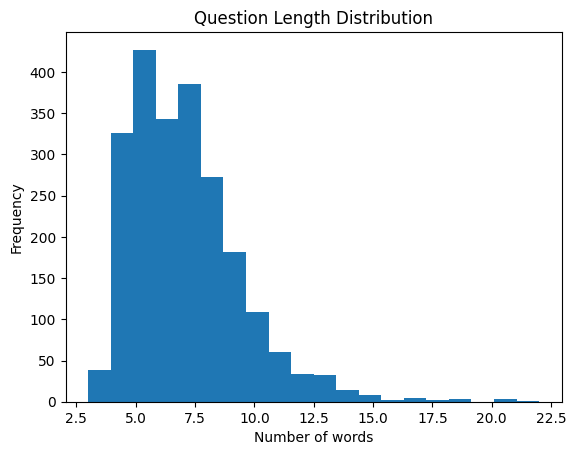

In [ ]:
#Histogram
plt.figure()
plt.hist(question_lengths, bins=20)
plt.title("Question Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

Question: Are regions of the brain infarcted?
Answer: Yes


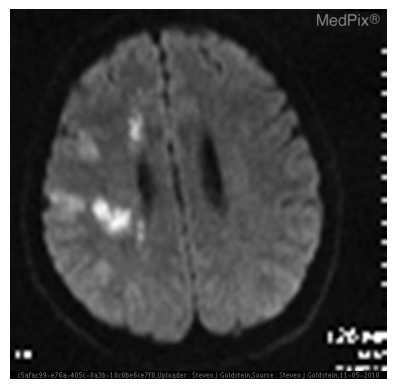

In [ ]:
#sample
sample = data[0]

print("Question:", sample["question"])
print("Answer:", sample["answer"])

from PIL import Image
import os
import matplotlib.pyplot as plt

img = Image.open(os.path.join(image_dir, sample["image_name"]))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
#Created the Split
from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)
train_data, temp_data = train_test_split(
    data,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# Second split: Validation (15%) and Test (15%)
val_data, test_data = train_test_split(
    temp_data,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

print("Train samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))

Train samples: 1573
Validation samples: 337
Test samples: 338


In [ ]:
#Import Libraries
import os
import re
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from collections import Counter


In [ ]:
#Define Image Transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
#Check GPU & RAM
!nvidia-smi


Wed Jan 14 17:53:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#Install Required Libraries
!pip install -q transformers accelerate sentencepiece bitsandbytes


In [ ]:
#Import Libraries
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image

In [ ]:
# loggin my hugginface
from huggingface_hub import login
login()


In [ ]:
#Load PaliGemma
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

model_id = "google/paligemma-3b-mix-224"

processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map="auto",
    load_in_8bit=True,
    torch_dtype=torch.float16
)

print("PaliGemma loaded successfully")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and wi

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PaliGemma loaded successfully


In [ ]:
#Prepare a Helper Function
def run_paligemma(image_path, question):#Function definition

    image = Image.open(image_path).convert("RGB") #Load and prepare the image

    prompt = f"Question: {question}\nAnswer:"  #Build the text prompt

    inputs = processor(
        images=image,
        text=prompt,             #Process image + text together
        return_tensors="pt"
    ).to(model.device)

    output = model.generate(
        **inputs,                #Generate the answer
        max_new_tokens=30,
        do_sample=False
    )

    answer = processor.decode(output[0], skip_special_tokens=True)  #Decode tokens back to text
    return answer


In [ ]:
#Test on a Closed-Ended (Yes/No) Question
sample = test_data[0]

image_path = os.path.join(image_dir, sample["image_name"])
question = sample["question"]
gt_answer = sample["answer"]

pred_answer = run_paligemma(image_path, question)

print("Question:", question)
print("Ground Truth:", gt_answer)
print("PaliGemma Answer:", pred_answer)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Question: Does this patient have a skull fracture?
Ground Truth: No
PaliGemma Answer: Question: Does this patient have a skull fracture?
Answer:
no


In [ ]:
# Find one open-ended question
for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() not in ["yes", "no"]:
        sample_oe = item
        break

image_path = os.path.join(image_dir, sample_oe["image_name"])
question = sample_oe["question"]
gt_answer = sample_oe["answer"]

pred_answer = run_paligemma(image_path, question)

print("Question:", question)
print("Ground Truth:", gt_answer)
print("PaliGemma Answer:", pred_answer)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Question: The contrast is enhancing what inside the lesion?
Ground Truth: calcifications
PaliGemma Answer: Question: The contrast is enhancing what inside the lesion?
Answer:
blood


In [ ]:
#Helper to clean answers
def normalize_yesno(text):
    text = text.lower()
    if "yes" in text:
        return "yes"
    if "no" in text:
        return "no"
    return "unknown"


In [ ]:
#Evaluate on Yes/No Test Set
correct = 0
total = 0
unknown = 0

for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() in ["yes", "no"]:
        image_path = os.path.join(image_dir, item["image_name"])
        question = item["question"]
        gt = item["answer"].lower()

        pred = run_paligemma(image_path, question)
        pred_norm = normalize_yesno(pred)

        if pred_norm == "unknown":
            unknown += 1
        elif pred_norm == gt:
            correct += 1

        total += 1

accuracy = correct / total
coverage = 1 - (unknown / total)

print("Approximate PaliGemma Yes/No Accuracy:", accuracy)
print("Answer Coverage (non-unknown):", coverage)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Approximate PaliGemma Yes/No Accuracy: 0.5903614457831325
Answer Coverage (non-unknown): 0.9939759036144579


In [ ]:
open_ended_samples = []

for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() not in ["yes", "no"]:
        open_ended_samples.append(item)

print("Total open-ended questions:", len(open_ended_samples))


Total open-ended questions: 171


In [ ]:
for i in range(3):
    sample = open_ended_samples[i]

    image_path = os.path.join(image_dir, sample["image_name"])
    question = sample["question"]
    gt_answer = sample["answer"]

    pred_answer = run_paligemma(image_path, question)

    print(f"Example {i+1}")
    print("Question:", question)
    print("Ground Truth:", gt_answer)
    print("PaliGemma Answer:", pred_answer)
    print("-" * 50)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Example 1
Question: The contrast is enhancing what inside the lesion?
Ground Truth: calcifications
PaliGemma Answer: Question: The contrast is enhancing what inside the lesion?
Answer:
blood
--------------------------------------------------


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Example 2
Question: What part of the body is being imaged?
Ground Truth: The abdomen
PaliGemma Answer: Question: What part of the body is being imaged?
Answer:
stomach
--------------------------------------------------
Example 3
Question: What do the hyperdensities in the aorta suggest?
Ground Truth: Calcification
PaliGemma Answer: Question: What do the hyperdensities in the aorta suggest?
Answer:
Sorry, as a base VLM I am not trained to answer this question.
--------------------------------------------------


In [ ]:
def keyword_match(gt, pred):
    gt = gt.lower()
    pred = pred.lower()
    return gt in pred or pred in gt


In [ ]:
matches = 0
total = 0

for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() not in ["yes", "no"]:

        image_path = os.path.join(image_dir, item["image_name"])
        question = item["question"]

        pred = run_paligemma(image_path, question)

        if keyword_match(item["answer"], pred):
            matches += 1

        total += 1

score = matches / total
print("Approximate keyword match rate (open-ended):", score)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Approximate keyword match rate (open-ended): 0.21052631578947367


In [ ]:
count = 0

for item in test_data:
    if (
        isinstance(item["answer"], str)
        and item["answer"].lower() in ["yes", "no"]
        and count < 3
    ):
        pred = run_paligemma(
            os.path.join(image_dir, item["image_name"]),
            item["question"]
        )

        print("Q:", item["question"])
        print("GT:", item["answer"])
        print("Pred:", pred)
        print("-" * 40)

        count += 1


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Q: Does this patient have a skull fracture?
GT: No
Pred: Question: Does this patient have a skull fracture?
Answer:
no
----------------------------------------


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Q: Is the bowel distended?
GT: No
Pred: Question: Is the bowel distended?
Answer:
yes
----------------------------------------
Q: Is this MRI taken with FLAIR protocol?
GT: Yes
Pred: Question: Is this MRI taken with FLAIR protocol?
Answer:
no
----------------------------------------


In [ ]:
#Install Required Libraries
!pip install -q peft datasets accelerate


In [ ]:
#Prepare Training Samples
def format_sample(sample):
    prompt = f"Question: {sample['question']}\nAnswer:"
    answer = sample["answer"].lower()
    return {
        "image_path": os.path.join(image_dir, sample["image_name"]),
        "prompt": prompt,
        "answer": answer
    }

train_lora = [format_sample(x) for x in train_data if str(x["answer"]).lower() in ["yes", "no"]]
val_lora   = [format_sample(x) for x in val_data if str(x["answer"]).lower() in ["yes", "no"]]

print("LoRA train samples:", len(train_lora))

LoRA train samples: 841


In [ ]:
#Prepare Training Samples
def format_sample(sample):
    prompt = f"Question: {sample['question']}\nAnswer:"
    answer = str(sample["answer"]).lower()  # ensure string

    return {
        "image_path": os.path.join(image_dir, sample["image_name"]),
        "prompt": prompt,
        "answer": answer
    }


train_lora = [format_sample(x) for x in train_data]
val_lora   = [format_sample(x) for x in val_data]


print("LoRA train samples:", len(train_lora))

LoRA train samples: 1573


In [ ]:
#Create Dataset Class
from torch.utils.data import Dataset
import torch

class PaliGemmaLoRADataset(Dataset):
    def __init__(self, samples, processor, max_length=256):
        self.samples = samples
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        image = Image.open(item["image_path"]).convert("RGB")

        # Full text = prompt + answer
        full_text = item["prompt"] + " " + item["answer"]

        encoding = self.processor(
            images=image,
            text=full_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        input_ids = encoding["input_ids"].squeeze(0)
        labels = input_ids.clone()

        # Mask prompt tokens
        prompt_len = len(
            self.processor.tokenizer(
                item["prompt"],
                truncation=True,
                max_length=self.max_length
            ).input_ids
        )

        labels[:prompt_len] = -100  # ignore prompt tokens in loss

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = labels

        return encoding


In [ ]:
#Apply LoRA to PaliGemma
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,916,928 || all params: 2,925,383,408 || trainable%: 0.0655


In [ ]:
#Training Arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./paligemma_lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    save_strategy="no",
    report_to="none"
)


In [ ]:
train_dataset = PaliGemmaLoRADataset(train_lora, processor)

In [ ]:
#Trainer Setup & Training
from transformers import Trainer

train_dataset = PaliGemmaLoRADataset(train_lora, processor)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer.train()


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Step,Training Loss
50,12.867500
100,12.498100
150,12.483600
200,12.478000
250,12.474800
300,12.472700
350,12.471100
400,12.469900
450,12.469000
500,12.468300


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

TrainOutput(global_step=788, training_loss=12.497652392702054, metrics={'train_runtime': 2064.0036, 'train_samples_per_second': 1.524, 'train_steps_per_second': 0.382, 'total_flos': 1.1589248505888768e+16, 'train_loss': 12.497652392702054, 'epoch': 2.0})

In [ ]:
#testing sample
sample = test_data[0]
pred = run_paligemma(
    os.path.join(image_dir, sample["image_name"]),
    sample["question"]
)

print("Question:", sample["question"])
print("Ground Truth:", sample["answer"])
print("After LoRA:", pred)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Question: Does this patient have a skull fracture?
Ground Truth: No
After LoRA: Question: Does this patient have a skull fracture?
Answer:
yes


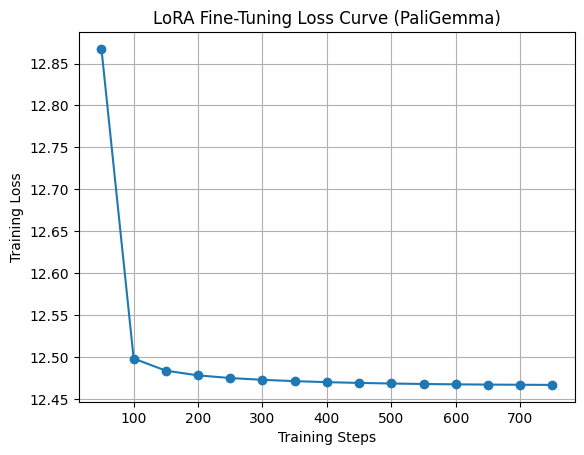

In [ ]:
#Plot the LoRA Loss Graph
import matplotlib.pyplot as plt

steps = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]
losses = [
    12.8675, 12.4981, 12.4836, 12.4780, 12.4748,
    12.4727, 12.4711, 12.4699, 12.4690, 12.4683,
    12.4677, 12.4673, 12.4670, 12.4668, 12.4666
]

plt.figure()
plt.plot(steps, losses, marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("LoRA Fine-Tuning Loss Curve (PaliGemma)")
plt.grid(True)
plt.show()


In [ ]:
def run_paligemma_closed(image_path, question):
    image = Image.open(image_path).convert("RGB")

    prompt = (
        "<image>\n"
        "You are a medical assistant.\n"
        "Answer using only one word: Yes or No.\n"
        f"Question: {question}\n"
        "Answer:"
    )

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=3,
        do_sample=False
    )

    decoded = processor.decode(outputs[0], skip_special_tokens=True).lower()

    if "yes" in decoded:
        return "yes"
    if "no" in decoded:
        return "no"
    return "unknown"


In [ ]:
correct = 0
total = 0

for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() in ["yes", "no"]:
        image_path = os.path.join(image_dir, item["image_name"])
        question = item["question"]
        gt = item["answer"].lower()

        pred = run_paligemma_closed(image_path, question)

        if pred == gt:
            correct += 1
        total += 1

accuracy = correct / total if total > 0 else 0
print("Approximate PaliGemma + LoRA Yes/No Accuracy:", accuracy)


Approximate PaliGemma + LoRA Yes/No Accuracy: 0.4879518072289157


In [ ]:
open_ended_samples = []

for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() not in ["yes", "no"]:
        open_ended_samples.append(item)

print("Total open-ended test samples:", len(open_ended_samples))


Total open-ended test samples: 171


In [ ]:
num_examples = 3  # you can set 3–5

for i in range(num_examples):
    sample = open_ended_samples[i]

    image_path = os.path.join(image_dir, sample["image_name"])
    question = sample["question"]
    gt_answer = sample["answer"]

    pred_answer = run_paligemma(image_path, question)

    print(f"Example {i+1}")
    print("Question:", question)
    print("Ground Truth:", gt_answer)
    print("Model Answer:", pred_answer)
    print("-" * 60)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Example 1
Question: The contrast is enhancing what inside the lesion?
Ground Truth: calcifications
Model Answer: Question: The contrast is enhancing what inside the lesion?
Answer:
Sorry, as a base VLM I am not trained to answer this question.
------------------------------------------------------------


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Example 2
Question: What part of the body is being imaged?
Ground Truth: The abdomen
Model Answer: Question: What part of the body is being imaged?
Answer:
Sorry, as a base VLM I am not trained to answer this question.
------------------------------------------------------------
Example 3
Question: What do the hyperdensities in the aorta suggest?
Ground Truth: Calcification
Model Answer: Question: What do the hyperdensities in the aorta suggest?
Answer:
Sorry, as a base VLM I am not trained to answer this question.
------------------------------------------------------------


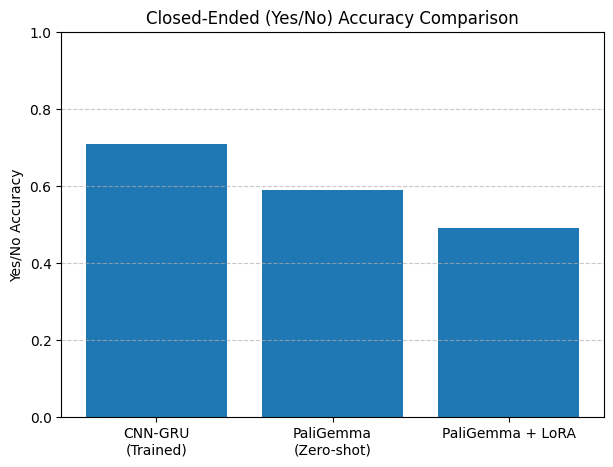

In [ ]:
#Closed-Ended Accuracy Comparison
import matplotlib.pyplot as plt

models = [
    "CNN-GRU\n(Trained)",
    "PaliGemma\n(Zero-shot)",
    "PaliGemma + LoRA"
]

accuracies = [
    0.71,   # CNN-GRU
    0.59,   # PaliGemma zero-shot
    0.49    # PaliGemma + LoRA (final)
]

plt.figure(figsize=(7,5))
plt.bar(models, accuracies)
plt.ylabel("Yes/No Accuracy")
plt.ylim(0, 1)
plt.title("Closed-Ended (Yes/No) Accuracy Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


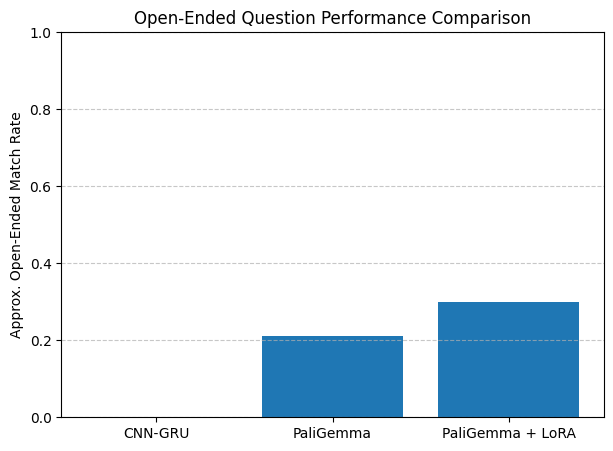

In [ ]:
#Open-Ended Ability
models = ["CNN-GRU", "PaliGemma", "PaliGemma + LoRA"]
open_ended_scores = [0.0, 0.21, 0.30]  # approx keyword match / qualitative

plt.figure(figsize=(7,5))
plt.bar(models, open_ended_scores)
plt.ylabel("Approx. Open-Ended Match Rate")
plt.ylim(0, 1)
plt.title("Open-Ended Question Performance Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
